## 1. 파노라마(panorama) 영상 만들기
### 1) 과정
#### ① 지역 특징 추출
- SIFT(Scale Invariant Feature Transform) 검출기를 사용하여 각각의 영상에서 지역 특징점 검출

#### ② 대응점 매칭
- ①에서 찾은 지역 특징점 간 매칭 수행
- 영상 1의 i번째 특징 $a_i$와 대응되는 영상 2의 j번째 특징 $b_j$를 찾은 후, 매칭 쌍으로 저장함  
- 매칭 전략    
  - 1) 고정 임계값 사용  
    - $d(a_i,b_j) < T$
  - 2) 최근접 특징 벡터 탐색
  - 3) 최근접 거리 비율 **(실습에서는 이 매칭 방식 사용)**
    - $\frac{d(a_i,b_j)}{d(a_i,b_k)} < T$  
    - $a_i$와 거리가 가까운 상위 2개의 대응점 $b_j$와 $b_k$을 찾은 후, 미리 설정한 거리 비율을 만족하는 특징만 저장함 (즉, 확실한 매칭쌍만 남김)

#### ③ 변환 행렬($H$) 추정
- 영상 1과 영상 2 사이의 다수의 매칭쌍으로부터 **RANSAC(RANdom SAmple Consencus)**을 이용하여 변환 행렬 추정  
- RANSAC은 이상점(outlier)이 포함된 데이터셋에서 어떠한 모델을 예측할 때 효과적인 방법임


$$
\begin{equation}  
    H = \begin{bmatrix}  
        h_{00} & h_{01} & h_{02} \\  
        h_{10} & h_{11} & h_{12} \\  
        h_{20} & h_{21} & h_{22} \\  
        \end{bmatrix}  
\end{equation}  
$$  

$$
\begin{equation}
    \begin{bmatrix}
        x' \\
        y' \\
        1
    \end{bmatrix} 
    = H
    \begin{bmatrix}
        x \\
        y \\
        1
    \end{bmatrix}
    =
    \begin{bmatrix}
        h_{00} & h_{01} & h_{02} \\
        h_{10} & h_{11} & h_{12} \\
        h_{20} & h_{21} & h_{22}
    \end{bmatrix}
    \begin{bmatrix}
        x \\
        y \\
        1
    \end{bmatrix}
\end{equation}
$$

#### ④ 원근 변환(perspective transform ≒ homography) 적용
- 추정된 변환 행렬 $H$를 이용하여 영상 2에 원근 변환 적용

#### ⑤ 두 영상 이어붙이기
- 파노라마 결과 영상 = 영상 1 + 변환된 영상 2

###  2. Practice

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [19]:
img_1 = cv2.imread('left.jpg')
img_1 = cv2.resize(img_1, None, fx=0.5, fy=0.5)
gray_1 = cv2.cvtColor(img_1,cv2.COLOR_BGR2GRAY)
img_2 = cv2.imread('right.jpg')
img_2 = cv2.resize(img_2, None, fx=0.5, fy=0.5)
gray_2 = cv2.cvtColor(img_2,cv2.COLOR_BGR2GRAY)

## 1) 각각의 영상에서 SIFT 특징 추출
sift = cv2.xfeatures2d.SIFT_create()
kp_1, des_1 = sift.detectAndCompute(gray_1, None)
kp_2, des_2 = sift.detectAndCompute(gray_2, None)

## 2-1) 두 영상의 지역 특징 간 거리 계산
bf = cv2.BFMatcher()
matches = bf.knnMatch(queryDescriptors = des_1,
                      trainDescriptors = des_2,
                      k=2)   # queryDescriptors의 각 특징점마다 거리가 가장 가까운 상위 k개의 trainDescriptors 특징점을 찾아줌

## 2-2) '최근접 거리 비율' 매칭 전략('ratio testing')을 사용하여 매칭쌍 생성
ratio = 0.7  # 보통 0.7 ~ 0.8 값 사용
good = []    # 좋은 대응점 쌍만 따로 저장할 리스트
for m,n in matches:   # m: 가장 가까운 매칭쌍 / n: 2번째로 가까운 매칭쌍
    if m.distance < n.distance * ratio:
        good.append(m)
        
print("# of original matching pairs: %d" % len(des_1))
print("# of good matching pairs: %d" % len(good))

# of original matching pairs: 1253
# of good matching pairs: 244


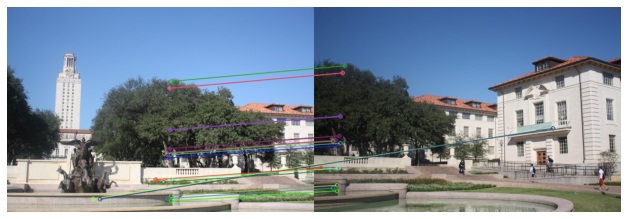

In [20]:
## optional) SIFT 특징점 매칭 결과 확인하기
matched = cv2.drawMatches(img1 = img_1, 
                          keypoints1 = kp_1, 
                          img2 = img_2, 
                          keypoints2 = kp_2, 
                          matches1to2 = good[:20],   # 첫 20개 매칭쌍만 시각화
                          outImg = None, 
                          flags = 2)

matched = cv2.cvtColor(matched, cv2.COLOR_RGB2BGR)
plt.figure(figsize=(11, 11))
plt.imshow(matched)
plt.axis('off')
plt.show()

In [21]:
## 3) RANSAC을 이용한 변환 행렬 H 추정
## 참고. cv2.getPerspectiveTransform()와 cv2.findHomography()의 차이
##   cv2.getPerspectiveTransform() - 4개의 대응점 쌍을 입력하면 변환 행렬을 반환해줌
##   cv2.findHomography() - 4개 이상의 대응점 쌍을 입력하면 가장 대응점들을 가장 잘 만족하는 변환 행렬을 반환해줌
if len(good) >= 4:   # 4개 이상의 대응점이 존재해야 원근 변환 행렬을 추정 가능
    src_pts = np.float32([ kp_2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    H, _ = cv2.findHomography(srcPoints = src_pts, 
                              dstPoints = dst_pts, 
                              method = cv2.RANSAC, 
                              ransacReprojThreshold = 5)
    
    print("H.shape: {}".format(H.shape))
    print(H)
    
else:
    raise AssertionError("Can't find enough keypoints.")

H.shape: (3, 3)
[[ 7.63962771e-01  3.96619082e-02  2.22802978e+02]
 [-1.36374976e-01  9.12647255e-01  3.79107780e+01]
 [-4.27509237e-04 -6.28975390e-05  1.00000000e+00]]


### Homework ( ~ 12/02 12:00)
- 아래 코드의 '4) 원근 변환 적용', '5) 두 영상을 한 장으로 이어붙이기' 부분을 완성하여 파노라마 영상 만들기

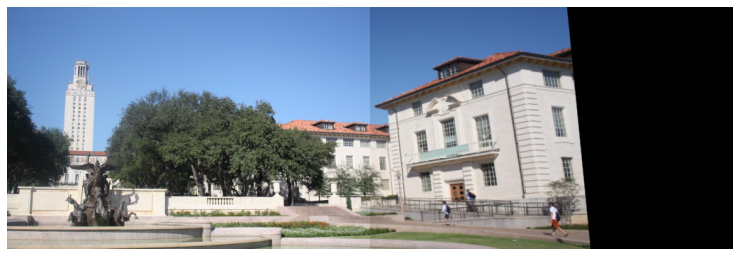

In [25]:
## 4) 원근 변환 적용
## 변환 행렬 H를 사용하여 변환 수행
## https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html#warpperspective

res = cv2.warpPerspective(src = img_2,
                          M = H,
                          dsize = (img_1.shape[1]+img_2.shape[1], img_1.shape[0]))

## 5) 두 영상을 한 장으로 이어붙이기

res[0:img_1.shape[0], 0:img_1.shape[1]] = img_1

res = cv2.cvtColor(res, cv2.COLOR_RGB2BGR)
## 결과 파노라마 영상 시각화
plt.figure(figsize=(11, 11))
plt.imshow(res)
plt.axis('off')
plt.show()



